# Heuristics Lab
The goal of this lab is to gain experience using heuristics in tandem with other algorithms.

For the purposes of this assignment, you will be implementing a solver for the "2048" game (whose implementation will already be given to you). Before continuing, the following cell contains any dependencies you may need for this assignment: 

In [1]:
import matplotlib.pyplot as plt

from game import *

You should also look at `game.py` to understand how the in-line version has been implemented. 

## Background Info

2048 is a single-player sliding block puzzle game played on a 4x4 grid where tiles containing even numbers can be moved around and merged to create larger numbers. If this does not ring a bell, it is highly recommended that you play the game at some point (enjoy the cupcake version [here](https://0x0800.github.io/2048-CUPCAKES/)).

While the implementation has been given, ensure that you understand what a tile, a turn, a legal move, and when the game ends is.

This particular implementation/walk through focuses on utilization of heuristic functions themselves (or strategies that are simple enough that a human player could follow them) & only looks ahead by 1 move (as opposed to adding this heuristic into another algorithm like nimimax or expectimax - which would yield better results)

Questions: 
1. What is a potential representation of the solution space?
2. How can you evaluate the results of a single move? 
3. How might you select and combine heuristics?
4. How can you evaluate the results of an entire game?


## A. Assessing the Problem

What is a potential representation of the solution space?

A respresentation of the solution space could include a set of all possible moves, (left right up down), and the board state after. 

Play a SINGLE round of 2048 (you can do this on the website with the nice UI instead of the text version). What score did you get?

7024 

## B. Evaluating a Single Move

Before implementing specific heuristics, a general implementation procedure must be formed.

Use the following pseudocode to write a function to evaluate a game _G_ in its current state:

**Input:** _G_ - a game, _M_ - a set of moves \
**Output:** The best moves according to the specific evaluator

**procedure** EvaluateGame(_G_, _M_)\
&emsp;_bestScore_ ← −1\
&emsp;_bestMoves_ ← ∅\
&emsp;**for all** _move_ ∈ _M_ **do**\
&emsp;&emsp;_G'_ ← _G_\
&emsp;&emsp;apply _move_ to _G'_\
&emsp;&emsp;_curScore_ ← the score given by the evaluator’s specific criteria\
&emsp;&emsp;**if** _curScore_ > _bestScore_ **then**\
&emsp;&emsp;&emsp;_bestScore_ ← _curScore_\
&emsp;&emsp;&emsp;_bestMoves_ ← {_move_}\
&emsp;&emsp;**else if** _curScore_ = _bestScore_ **then**\
&emsp;&emsp;&emsp;_bestMoves_ ← _bestMoves_ ∪ {_move_}\
&emsp;&emsp;**end if**\
&emsp;**end for**\
&emsp;return _bestMoves_\
**end procedure**

For now, use the overall game score as the evaluation criteria. Remember to consider how the game/board is referenced when running each move.

In [2]:
def evaluate_game(game, moves): 
    best_score = -1
    best_moves = []
    for move in moves:
        test_game = game
        test_game.move(move)
        current_score = test_game.score
        if current_score > best_score:
            best_score = current_score
            best_moves = [move]
        elif current_score == best_score:
            best_moves.append(move)
    return best_moves

## C. Selecting Heuristics

### Refactoring Evaluation

At this point in time, the solver uses a 'greedy' heuristic of purely selecting tiles based on the highest immediate increase to score.  Before we try other heuristics, let's refactor the `evaluate_move()` function to take in a heuristic function instead of hardcoding the evaluator's criteria. 

After updating the function, it can be tested with the given `game_score()` heuristic function.

In [38]:
def game_score(game):
    return game.score

def evaluate_game(games, moves, heuristic): 
    best_heuristic = -1
    best_moves = []
    for move in moves:
        test_game = games
        test_game.play_turn(move)
        test_heur = heuristic(test_game)
        if test_heur > best_heuristic:
            best_heuristic = heuristic(test_game)
            best_moves = [move]
        elif heuristic(test_game) == best_heuristic:
            best_moves.append(move)
    return best_moves

We should also define a random move selection function as a groud zero/baseline point of comparison.

In [39]:
def random_move(moves):
    return random.choice(moves)


### Various Heuristics

There are multiple heuristics that can be used to solve a 2048 game: 
- Greedy - approximates in-game score after each move & return the one with the highest result
- Monotincity - values are either non-increasing or non-decreasing along all rows and non-increasing or non-decreasing along all columns
- Empty - prioritizes moves that increases the # of empty tiles on the board
- Smoothness - keeps tiles of similar value close to each other
- Weight matrix - a grid w higher weighting tiles on one part of the grid (resulting in higher utility & the algorithm shifting tiles/converging them on one corner of weights)

Pick two heuristics (other than greedy - which you already did) & write functions calculating those. You may choose another heuristic that is not on this list if you would prefer that.

In [40]:
def empty(game):
    """
    An heuristic function to solve the 2048 game based on the amount of empty tiles

    Args:
        game: an instance of the Board object from the game.py file. 
    
    Returns:
        integer value representing the amount of empty tiles still on the board. 
    """
    board = game.board
    empty_tiles = []
    for r in range(4):
        for c in range(4): 
            if board[r, c] == 0:
                empty_tiles.append((r, c))
    return len(empty_tiles)


def monotincity(game):
    """
    A heuristic function to solve the 2048 game based on the amount of non-increasing/non-decreasing tiles

    Args:
        game: an instance of the Board object from the game.py file.
    
    Returns:
        integer value representing the number of increasing/decreasing rows/columns
    """
    board = game.board
    inc_dec = 0
    for r in range(4):
        row = board[r,:]
        if all(row[i] > row[i-1] for i in range(1, len(row))) or all(row[i] < row[i-1] for i in range(1, len(row))):
            inc_dec += 1
    for c in range(4):
        col = board[:,c]
        if all(col[i] > col[i-1] for i in range(1, len(col))) or all(col[i] < col[i-1] for i in range(1, len(col))):
            inc_dec += 1
    return inc_dec

## D. Evaluating a Game

### Making the Solver

Now that value has successfully been equated to the outcome of a single move, this needs to be done on the entire game. 

To start, your solver should take in a game and a heuristic to abide by. 

Most heuristic evaluators are non-terminal, meaning they will return more than one possible move of equal value. In order to combat this, a terminal evaluator must be included in the overall game solver to ensure only one move is selected. This can be done by randomly selecting from the list of "best moves" provided by the heuristic. 

In [45]:
def run_solver(game, heuristic):
    """
    Play a full game of 2048, using the heuristic algorithm on each move
    to determine the best move to perform.

    Args: 
        Game: an instance of the Board object from the game.py file
        Heuristic: a hueristic function to evaluate moves
    
    Returns:
        Final Score of the game after completion. 
    """
    move = [random_move(["w", "a", "s", "d"])]
    game.move(move)
    game_running = True
    while game_running:
        game_running = game.has_valid_moves()
        move = evaluate_game(game, ["w", "a", "s", "d"], heuristic)
        if len(move) > 1:
            game.play_turn(random.choice(move))
        else:
            game.play_turn(move)
    game.display()
    return game.score 


Run the following cell to test your solver on just the `game_score` heuristic:

In [71]:
g = Board()
run_solver(g, game_score)

Score: 1420
[[  2  16   8   2]
 [  4   2  32 128]
 [  2   8   4   2]
 [ 32  16   2  64]]


1420

Try the full game solver on some of your other heuristics. Note that sometimes they will flatline or get stuck in a pattern of moves that do not appear to converge in a termination point.

In [167]:
# Test other heuristics here
g = Board()
run_solver(g, monotincity)


Score: 2456
[[  4  16   4   2]
 [ 16 256  32   8]
 [  4  32  64  16]
 [  2   8   4   2]]


2456

#### Resolving Flatlining

One way to resolve flatlining is to to update the solver to count for a certain number of repeating moves and reintroduce a random selection.

In [332]:
def run_solver(game, heuristic): 
    threshold = 5 # Replace with your code (this can be a hardcoded value)
    previous_move = None
    repeat_count = 0
    move = [random_move(["w", "a", "s", "d"])]
    game.move(move)
    game_running = True
    while game_running:
        game_running = game.has_valid_moves()
        move = evaluate_game(game, ["w", "a", "s", "d"], heuristic)
        if len(move) > 1:
            move_to_make = random.choice(move)
        else:
            move_to_make = move
        if previous_move == move_to_make:
            repeat_count += 1
        if repeat_count >= threshold:
            move_to_make = random.choice(["w", "a", "s", "d"])
        previous_move = move_to_make
        game.play_turn(move_to_make)      
    #game.display() #Commented out to run 100 times because thats a lot lol
    return game.score 


g = Board()
run_solver(g, empty)


1600

#### Combining Heuristics 

A simple way to incorporate multiple heuristics is to create a `combined_heuristic()` function that assigns weights to various heuristics. These weights can also help offset any discrepancies in the scale of resulting "scores".

The combined score should be calculated by multiplying the weight of an individual heuristic's score with its score.

In [329]:
def combined_heuristic(game):
    # Heuristic 1 (Replace with your code)
    h1 = empty(game)
    # Heuristic 2 (Replace with your code)
    h2 = monotincity(game)
    # Assign weights to each heuristic
    h1_weight = .8
    h2_weight = .2
    # Combine heuristics
    combined_score = (h1 * h1_weight) + (h2 * h2_weight)

    return combined_score

g = Board()
run_solver(g, combined_heuristic)


Score: 1224
[[  8   2  32   2]
 [  4  32  16   4]
 [  2 128   4   2]
 [ 32   4   2  16]]


1224

### Plotting Results

Run 100 cycles of each of your heuristics & plot your results. You should have at least 3 lines (score, your heuristic #1, your heuristic #2, and potentially a completely random implementation)

In [338]:
combined_scores = []
empty_scores = []
monotincity_scores = []
game_score_scores = [] #lol variable names
x = range(300)
for _ in range(300):
    g0 = Board()
    run_solver(g0, combined_heuristic)
    combined_scores.append(g0.score)
    g1 = Board()
    run_solver(g1, empty)
    empty_scores.append(g1.score)
    g2 = Board()
    run_solver(g2, monotincity)
    monotincity_scores.append(g2.score)
    g3 = Board()
    run_solver(g3, game_score)
    game_score_scores.append(g3.score)
avg_comb = [sum(combined_scores) / len(combined_scores)] * len(x)
avg_empt = [sum(empty_scores) / len(empty_scores)] * len(x)
avg_mono = [sum(monotincity_scores) / len(monotincity_scores)] * len(x)
avg_sco = [sum(game_score_scores) / len(game_score_scores)] * len(x)



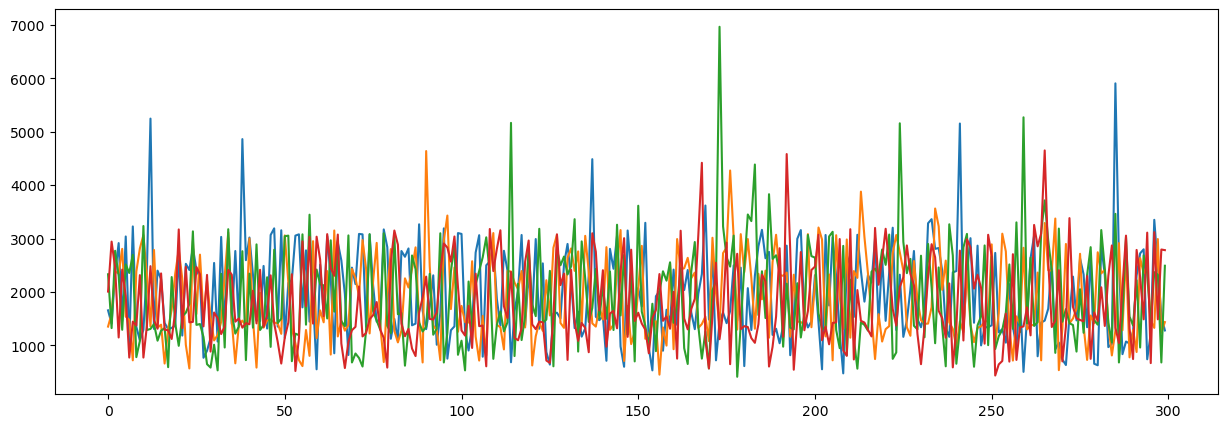

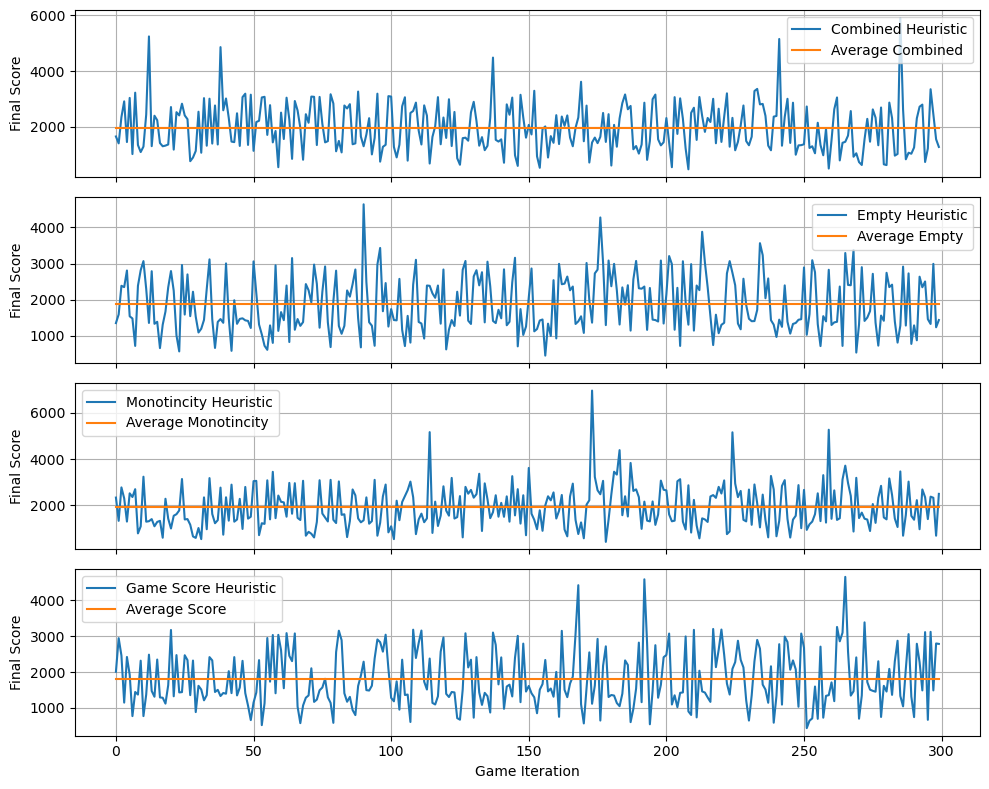

In [339]:
plt.figure(figsize=(15, 5))
plt.plot(x, combined_scores, label="Combined Heuristic")
plt.plot(x, empty_scores, label="Empty Heuristic")
plt.plot(x, monotincity_scores, label="Monotincity Heuristic")
plt.plot(x, game_score_scores, label="Game Score Heuristic")

fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axes[0].plot(x, combined_scores, label="Combined Heuristic", linestyle='-')
axes[0].plot(x, avg_comb, label="Average Combined", linestyle='-')
axes[1].plot(x, empty_scores, label="Empty Heuristic", linestyle='-')
axes[1].plot(x, avg_empt, label="Average Empty", linestyle='-')
axes[2].plot(x, monotincity_scores, label="Monotincity Heuristic", linestyle='-')
axes[2].plot(x, avg_mono, label="Average Monotincity", linestyle='-')
axes[3].plot(x, game_score_scores, label="Game Score Heuristic", linestyle='-')
axes[3].plot(x, avg_sco, label="Average Score", linestyle='-')

for i, ax in enumerate(axes):
    ax.set_ylabel("Final Score")
    ax.legend()
    ax.grid(True)
axes[-1].set_xlabel("Game Iteration")
plt.tight_layout()
plt.show()


I Got really picky about how the plots looked, so i tried it twice, Hopefully 1 of them is good. I feel like from these graphs I can tell that some heuristics are slightly better than others, but in the long run, None are perfect. I plotted the average of each heuristic on the second graph, which shows how all 4 methods i showed give us pretty much the same average score: about 2000. I also ran it 100 and 300 times, just to make sure the amount of runs was sufficient. 300 was definetly enough. 